In [3]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv to a Pandas df
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")

## Preprocess Data

In [4]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=["EIN", "NAME"], axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [5]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [6]:
inc_amt_counts = application_df.INCOME_AMT.value_counts()
inc_amt_counts

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

In [7]:
# Look at ASK_AMT value counts for binning
ask_amt_counts = application_df.ASK_AMT.value_counts()
ask_amt_counts

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

<AxesSubplot:ylabel='Density'>

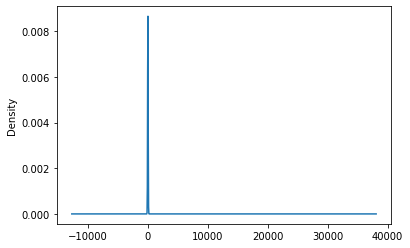

In [8]:
# Visualize the value counts of ASK_AMT
ask_amt_counts.plot.density()

In [9]:
# Determine which values to replace if counts are less than ...?
replace_ask_amt = list(ask_amt_counts[ask_amt_counts < 1000].index)

# Replace in dataframe
for amt in replace_ask_amt:
    if amt <= 49999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5001-49999"))
    elif amt < 99999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("50000-99999"))
    elif amt < 499999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("100000-499999"))
    elif amt < 999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("500000-999999"))
    elif amt < 4999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("1M-5M"))
    else:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5M+"))
    
application_df.ASK_AMT = application_df.ASK_AMT.astype(str)

# Check to make sure binning was successful
application_df.ASK_AMT.value_counts()

5000             25398
5001-49999        2947
100000-499999     2305
50000-99999       1421
1M-5M              940
500000-999999      651
5M+                637
Name: ASK_AMT, dtype: int64

In [10]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

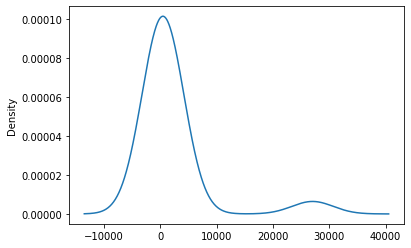

In [11]:
# Visualize the value counts of APPLICATION_TYPE
application_counts.plot.density()

In [12]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_counts[application_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [13]:
# Look at CLASSIFICATION value counts for binning
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

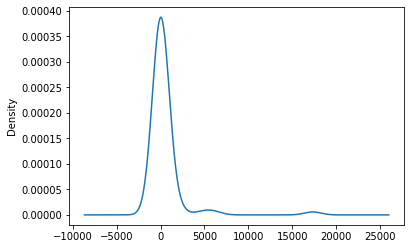

In [14]:
# Visualize the value counts of CLASSIFICATION
classification_counts.plot.density()

In [15]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_counts[classification_counts < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [16]:
# Generate our categorical variable lists
application_cat = ["APPLICATION_TYPE", "AFFILIATION", "CLASSIFICATION", "USE_CASE", "ORGANIZATION", "INCOME_AMT", 
                  "SPECIAL_CONSIDERATIONS", "ASK_AMT"]

In [18]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_100000-499999,ASK_AMT_1M-5M,ASK_AMT_5000,ASK_AMT_50000-99999,ASK_AMT_500000-999999,ASK_AMT_5001-49999,ASK_AMT_5M+
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True).drop(columns=application_cat, axis=1)
application_df.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_100000-499999,ASK_AMT_1M-5M,ASK_AMT_5000,ASK_AMT_50000-99999,ASK_AMT_500000-999999,ASK_AMT_5001-49999,ASK_AMT_5M+
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Split our preprocessed data into our features and target arrays
y = application_df.IS_SUCCESSFUL
X = application_df.drop("IS_SUCCESSFUL", axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [21]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Design a Neural Network Model

In [22]:
# Adding more neurons to a hidden layer
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 100
nodes_hidden_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

2022-05-22 22:40:58.357256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-22 22:40:58.357549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5000      
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8,061
Trainable params: 8,061
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_add_neurons/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_add_neurons/weights.{epoch:02d}hdf5"

In [25]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100


2022-05-22 22:41:23.558027: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-22 22:41:23.776917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


804/804 [==============================] - 5s 4ms/step - loss: 0.5707 - accuracy: 0.7213
Epoch 2/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5547 - accuracy: 0.7288
Epoch 3/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5496 - accuracy: 0.7324
Epoch 4/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5480 - accuracy: 0.7323
Epoch 5/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5458 - accuracy: 0.7343
Epoch 6/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5453 - accuracy: 0.7343
Epoch 7/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5431 - accuracy: 0.7351
Epoch 8/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5434 - accuracy: 0.7344
Epoch 9/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5422 - accuracy: 0.7343
Epoch 10/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5413 - accuracy: 0.7363
E

804/804 [==============================] - 3s 4ms/step - loss: 0.5251 - accuracy: 0.7448
Epoch 82/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5252 - accuracy: 0.7448
Epoch 83/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5246 - accuracy: 0.7438
Epoch 84/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5242 - accuracy: 0.7435
Epoch 85/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5249 - accuracy: 0.7444
Epoch 86/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5243 - accuracy: 0.7440
Epoch 87/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5239 - accuracy: 0.7460
Epoch 88/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5248 - accuracy: 0.7445
Epoch 89/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5242 - accuracy: 0.7453
Epoch 90/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5244 - accuracy: 

In [26]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2022-05-22 22:47:46.066771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


268/268 - 1s - loss: 0.5711 - accuracy: 0.7299 - 760ms/epoch - 3ms/step
Loss: 0.5711047649383545, Accuracy: 0.729912519454956


In [27]:
# More hidden layers
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 80
nodes_hidden_layer2 = 30
nodes_hidden_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 80)                4000      
                                                                 
 dense_4 (Dense)             (None, 30)                2430      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 6,751
Trainable params: 6,751
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [29]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_add_layer/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_add_layer/weights.{epoch:02d}hdf5"

In [30]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback], verbose=1)

Epoch 1/100


2022-05-22 22:48:41.540038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


804/804 [==============================] - 4s 5ms/step - loss: 0.5749 - accuracy: 0.7175
Epoch 2/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5558 - accuracy: 0.7272
Epoch 3/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5520 - accuracy: 0.7299
Epoch 4/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5483 - accuracy: 0.7317
Epoch 5/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5468 - accuracy: 0.7326
Epoch 6/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5459 - accuracy: 0.7322
Epoch 7/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5448 - accuracy: 0.7333
Epoch 8/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5436 - accuracy: 0.7337
Epoch 9/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5434 - accuracy: 0.7343
Epoch 10/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5421 - accuracy: 0.7349
E

804/804 [==============================] - 4s 4ms/step - loss: 0.5242 - accuracy: 0.7428
Epoch 82/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5242 - accuracy: 0.7446
Epoch 83/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5246 - accuracy: 0.7443
Epoch 84/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5251 - accuracy: 0.7434
Epoch 85/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5241 - accuracy: 0.7432
Epoch 86/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5241 - accuracy: 0.7444
Epoch 87/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5242 - accuracy: 0.7435
Epoch 88/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5245 - accuracy: 0.7439
Epoch 89/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5241 - accuracy: 0.7448
Epoch 90/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5236 - accuracy: 

In [31]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2022-05-22 22:57:41.523885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


268/268 - 1s - loss: 0.5712 - accuracy: 0.7283 - 760ms/epoch - 3ms/step
Loss: 0.5712494254112244, Accuracy: 0.7282798886299133


In [32]:
# Different act functions for the hidden layers
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 80
nodes_hidden_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="tanh", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 80)                4000      
                                                                 
 dense_8 (Dense)             (None, 30)                2430      
                                                                 
 dense_9 (Dense)             (None, 1)                 31        
                                                                 
Total params: 6,461
Trainable params: 6,461
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [34]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_change_activ/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_change_activ/weights.{epoch:02d}hdf5"

In [35]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback], verbose=1)

Epoch 1/100
 12/804 [..............................] - ETA: 3s - loss: 0.6790 - accuracy: 0.6042  

2022-05-22 22:58:37.793213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


804/804 [==============================] - 4s 4ms/step - loss: 0.5741 - accuracy: 0.7180
Epoch 2/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5565 - accuracy: 0.7279
Epoch 3/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5521 - accuracy: 0.7302
Epoch 4/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5494 - accuracy: 0.7291
Epoch 5/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5468 - accuracy: 0.7312
Epoch 6/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5461 - accuracy: 0.7327
Epoch 7/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5447 - accuracy: 0.7345
Epoch 8/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5434 - accuracy: 0.7336
Epoch 9/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5423 - accuracy: 0.7330
Epoch 10/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5415 - accuracy: 0.7352
E

804/804 [==============================] - 3s 4ms/step - loss: 0.5216 - accuracy: 0.7452
Epoch 82/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5212 - accuracy: 0.7461
Epoch 83/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5214 - accuracy: 0.7453
Epoch 84/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5212 - accuracy: 0.7453
Epoch 85/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5213 - accuracy: 0.7458
Epoch 86/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5214 - accuracy: 0.7458
Epoch 87/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5208 - accuracy: 0.7452
Epoch 88/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5210 - accuracy: 0.7454
Epoch 89/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5208 - accuracy: 0.7459
Epoch 90/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5208 - accuracy: 

In [36]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2022-05-22 23:19:06.475263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


268/268 - 1s - loss: 0.5649 - accuracy: 0.7287 - 743ms/epoch - 3ms/step
Loss: 0.5649111270904541, Accuracy: 0.7287463545799255


In [37]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization.h5")